# Insect Classification using Deep Convolutional Neural Networks and Transfer Learning

# Import Necessary Libraries

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomFlip

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Create helper functions

In [ ]:
import requests

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
r = requests.get(url)
with open("helper_functions.py", "w") as f:
    f.write(r.text)


In [ ]:

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# Load and transform data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
# Walk through each directory
dataset = "input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes"
walk_through_dir(dataset)

There are 10 directories and 0 images in 'input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes'.
There are 0 directories and 1000 images in 'input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes\Bees'.
There are 0 directories and 1000 images in 'input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes\Beetles'.
There are 0 directories and 1000 images in 'input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes\Butterfly'.
There are 0 directories and 1000 images in 'input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes\Cicada'.
There are 0 directories and 1000 images in 'input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes\Dragonfly'.
There are 0 directories and 1000 images in 'input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes\Grasshopper'.
There are 0 directories and 1000 images 

# Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath   Label
0      input\insect-village-synthetic-dataset\Insect ...    Bees
1      input\insect-village-synthetic-dataset\Insect ...    Bees
2      input\insect-village-synthetic-dataset\Insect ...    Bees
3      input\insect-village-synthetic-dataset\Insect ...    Bees
4      input\insect-village-synthetic-dataset\Insect ...    Bees
...                                                  ...     ...
19995  input\insect-village-synthetic-dataset\Insect ...  Spider
19996  input\insect-village-synthetic-dataset\Insect ...  Spider
19997  input\insect-village-synthetic-dataset\Insect ...  Spider
19998  input\insect-village-synthetic-dataset\Insect ...  Spider
19999  input\insect-village-synthetic-dataset\Insect ...  Spider

[20000 rows x 2 columns]

# Visualizing images from the dataset

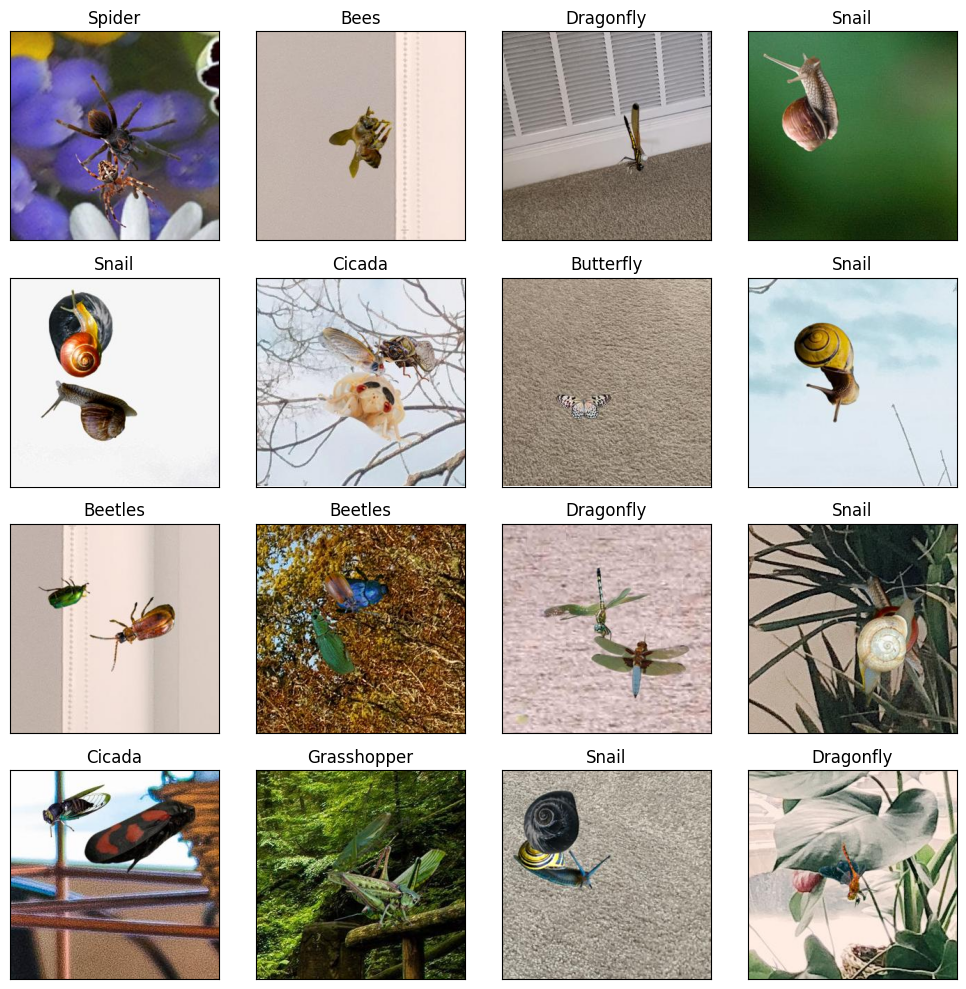

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 16 unique indices
random_index = np.random.choice(len(image_df), 16, replace=False)

# Create 4x4 grid for images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

# Display images and their labels
for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df.Filepath[random_index[i]])
    label = image_df.Label[random_index[i]]
    ax.imshow(img)
    ax.set_title(label)

plt.tight_layout()
plt.show()


# Computing Error Rate Analysis

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

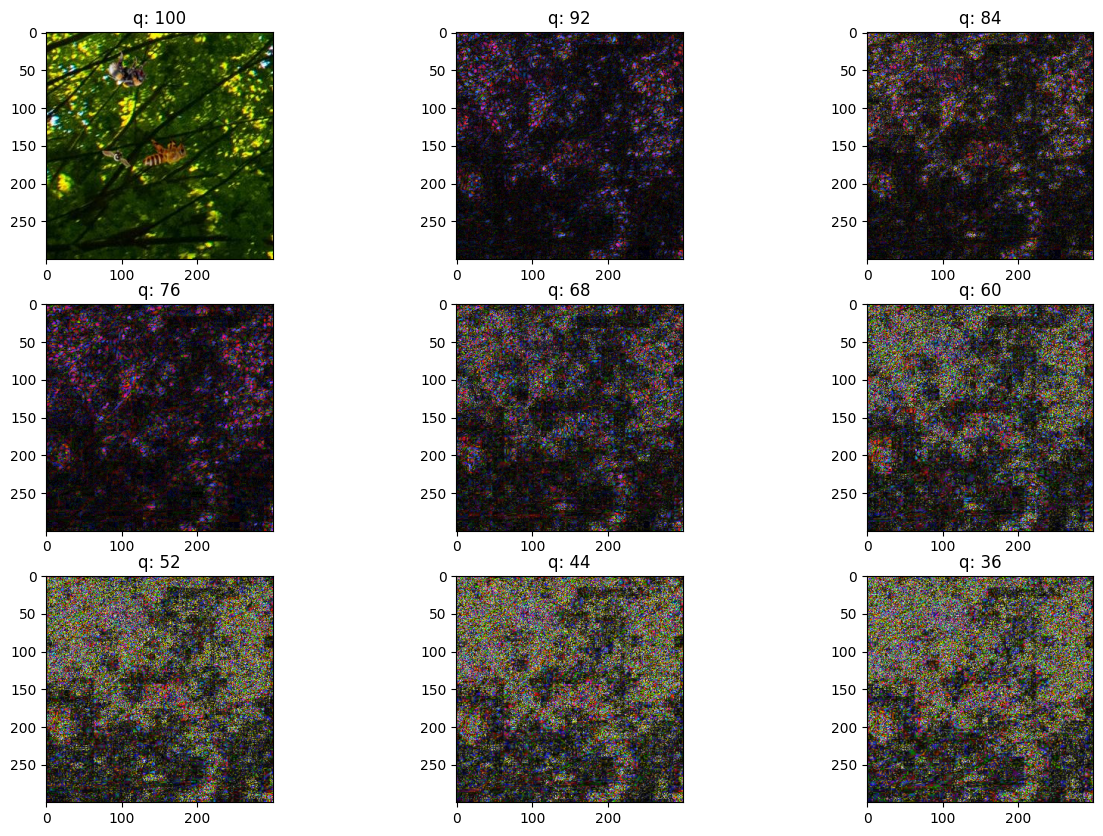

In [ ]:
# View random sample from the dataset
p = random_sample('input/insect-village-synthetic-dataset/Insect Classes/Insect Classes/Insect Classes/Bees')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Data Preprocessing

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12800 validated image filenames belonging to 10 classes.
Found 3200 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(300, 300),
    layers.Rescaling(1.0/255)
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),                       
], name="data_augmentation")

# Training the model

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "insect_classification_model_checkpoint.weights.h5" # Add .weights.h5 extension for it to work
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

# Train the model

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001), # adjust if needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "insect_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/insect_classification/20250506-202316


c:\Users\Chazz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 189s 461ms/step - accuracy: 0.1315 - loss: 2.4601 - val_accuracy: 0.3628 - val_loss: 1.9591
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 158s 396ms/step - accuracy: 0.3072 - loss: 1.9981 - val_accuracy: 0.5291 - val_loss: 1.6217
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 154s 385ms/step - accuracy: 0.4337 - loss: 1.7042 - val_accuracy: 0.6284 - val_loss: 1.3482
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 152s 381ms/step - accuracy: 0.5335 - loss: 1.4658 - val_accuracy: 0.6803 - val_loss: 1.1410
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 153s 382ms/step - accuracy: 0.5914 - loss: 1.2746 - val_accuracy: 0.7109 - val_loss: 0.9988
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 153s 383ms/step - accuracy: 0.6214 - loss: 1.1508 - val_accuracy: 0.7350 - val_loss: 0.8986
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 152s 381ms/step - accuracy: 0.6708 - loss: 1.0254 - val_accuracy: 0.7547 - val_loss: 0.8260
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 153s 383ms/step - accuracy: 

In [ ]:
model.save("insect_classification_model.keras")

# Pickle metadata (e.g., path, labels)
metadata = {
    "model_path": "insect_classification_model.keras",
    "class_names": ["Bees", "Beetles", "Butterfly", "Cicada", "Dragonfly", "Grasshopper", "Moth", "Scorpion", "Snail","Spider"]  
}
with open("model_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

# Model Evaluation

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.24453
Test Accuracy: 92.98%


# Visualizing loss curves

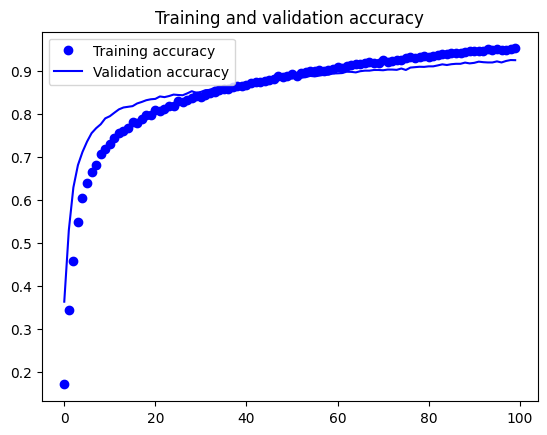

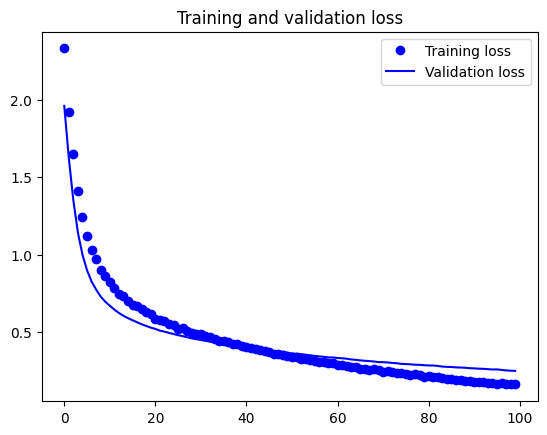

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# Making predictions on the test data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 870ms/step
The first 5 predictions: ['Beetles', 'Moth', 'Cicada', 'Snail', 'Beetles']


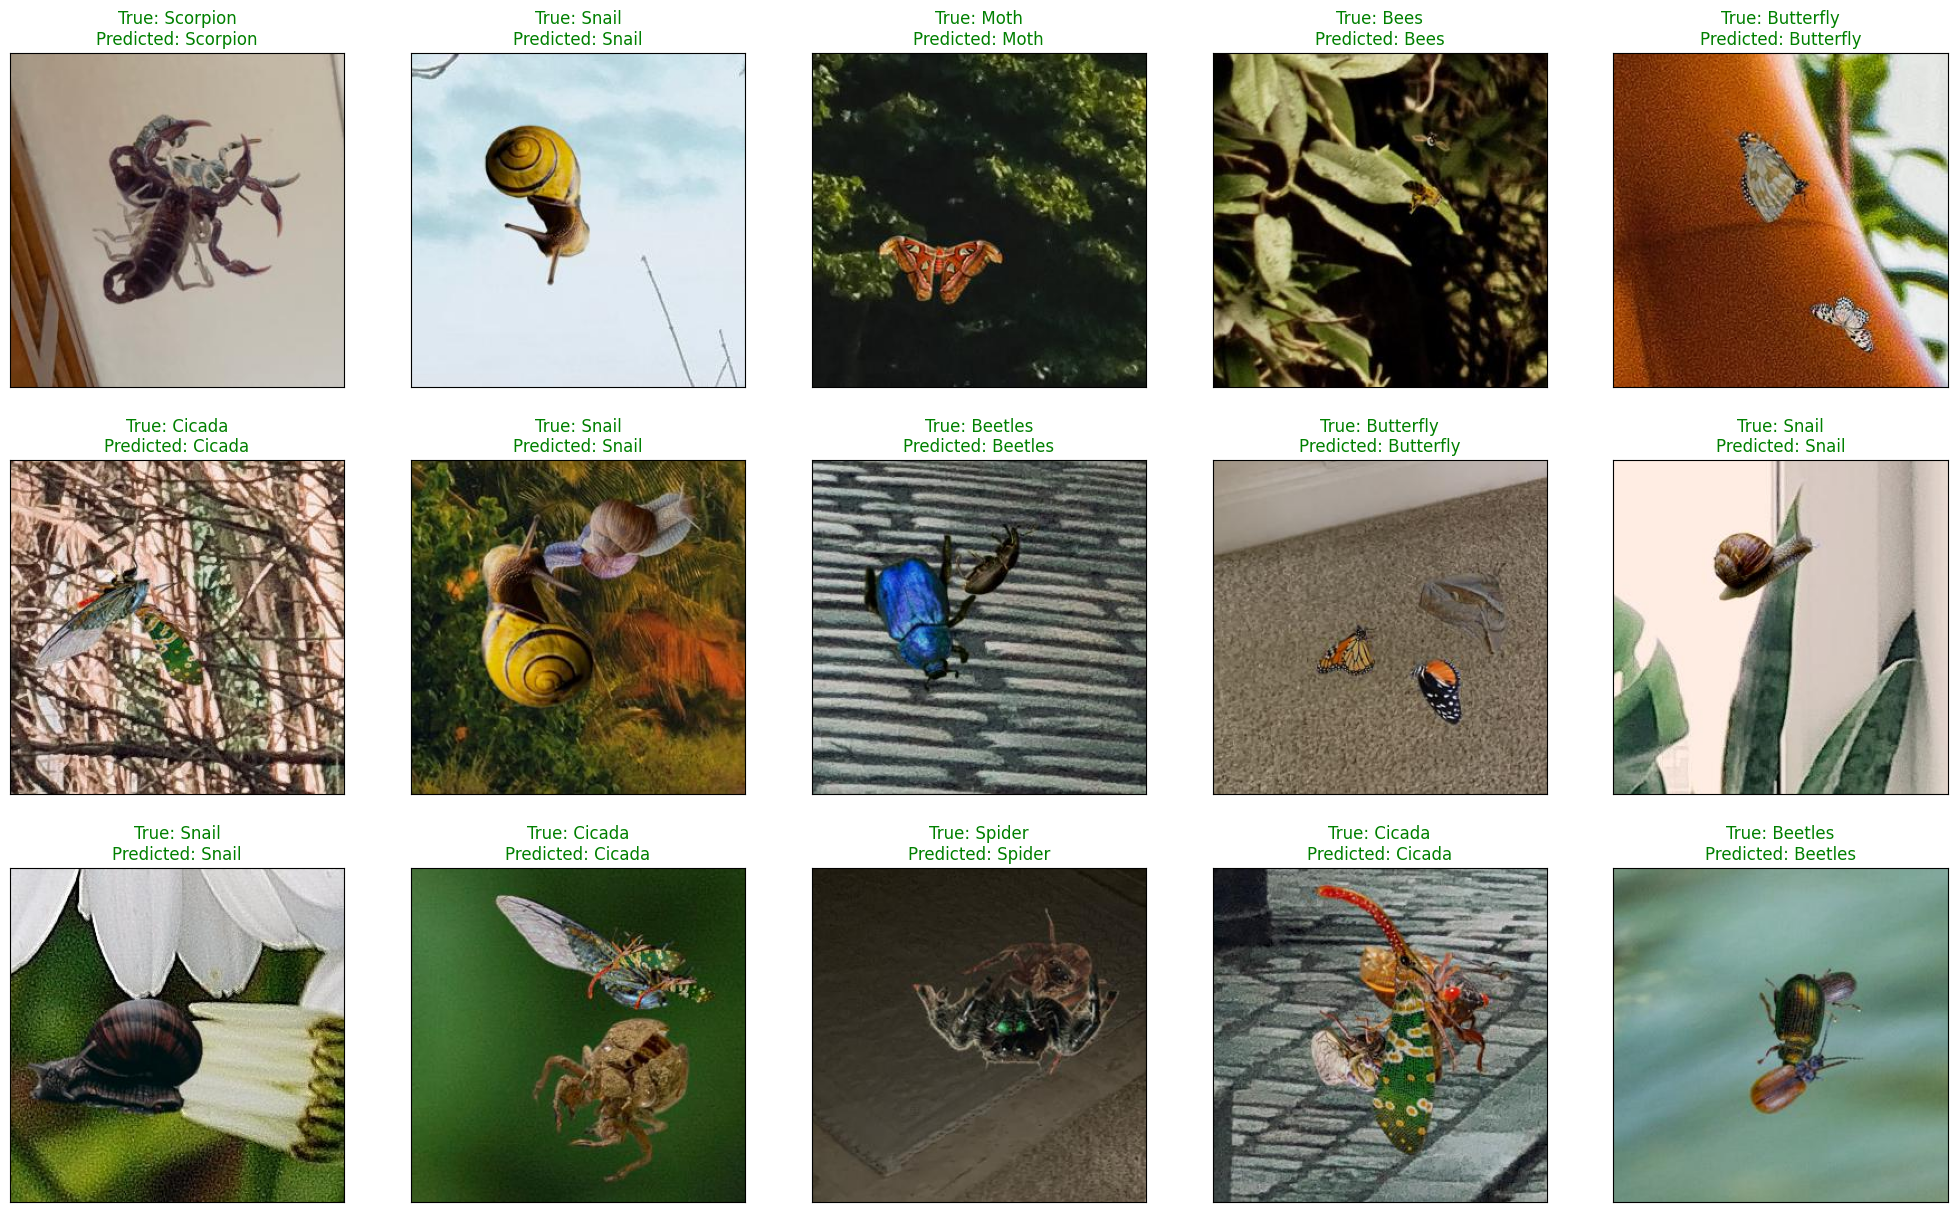

<Figure size 640x480 with 0 Axes>

In [ ]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the classification reports and confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        Bees       0.91      0.94      0.92       418
     Beetles       0.90      0.92      0.91       412
   Butterfly       0.97      0.94      0.95       412
      Cicada       0.97      0.93      0.95       381
   Dragonfly       0.90      0.89      0.90       392
 Grasshopper       0.91      0.91      0.91       414
        Moth       0.91      0.95      0.93       377
    Scorpion       0.91      0.93      0.92       364
       Snail       0.99      0.99      0.99       414
      Spider       0.94      0.90      0.92       416

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Bees           0.905093  0.935407  0.920000   418.00000
Beetles        0.902381  0.919903  0.911058   412.00000
Butterfly      0.965087  0.939320  0.952030   412.00000
Cicada         0.969945  0.931759  0.950469   381.00000
Dragonfly      0.904145  0.890306  0.897172   392.00000
Grasshopper    0.906475  0.913043  0.909747   414.00000
Moth           0.911392  0.954907  0.932642   377.00000
Scorpion       0.906166  0.928571  0.917232   364.00000
Snail          0.992718  0.987923  0.990315   414.00000
Spider         0.937186  0.896635  0.916462   416.00000
accuracy       0.929750  0.929750  0.929750     0.92975
macro avg      0.930059  0.929777  0.929713  4000.00000
weighted avg   0.930319  0.929750  0.929831  4000.00000

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=10, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


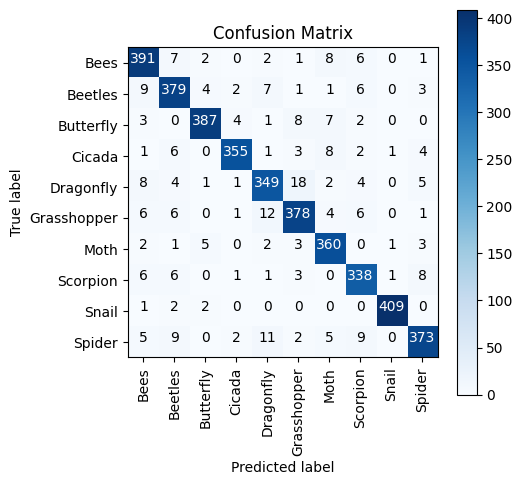

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# Grad-Cam Visualization

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\Chazz\AppData\Local\Temp\ipykernel_35784\1921096387.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


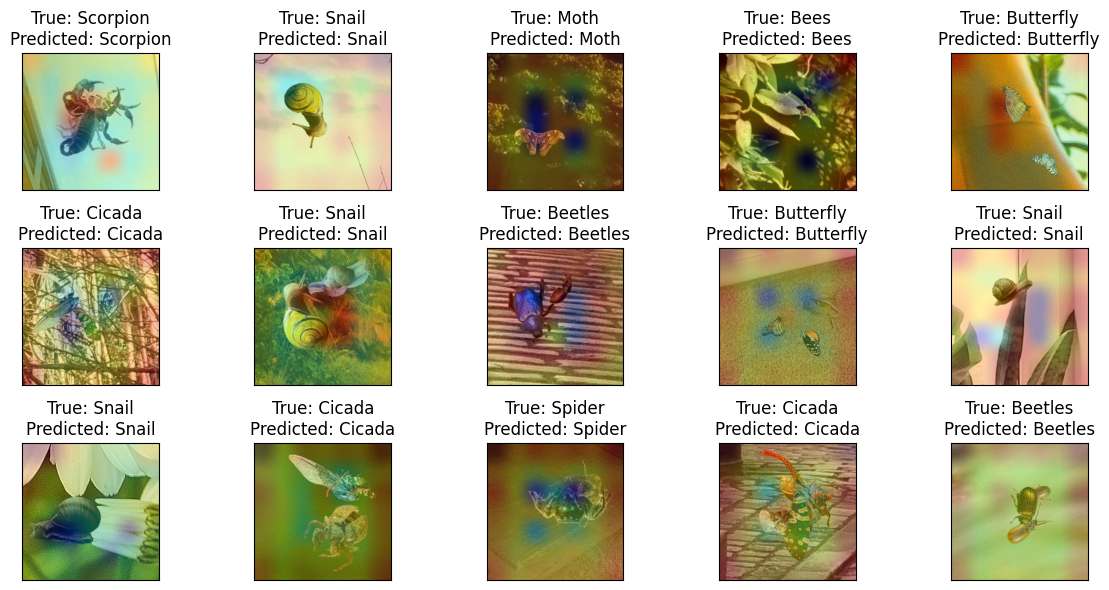

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()